<h1 style = "text-align:center; font-size:300%">Credit Card Fraud Detection</h1>

---

## Feature Explanation:
- **distance_from_home:** the distance from the home where the transaction happened.
- **distance_from_last_transaction:** the distance from the last transaction that happened.
- **ratio_to_median_purchase_price:** Ratio of purchased price transaction to median purchase price.
- **repeat_retailer:** Does the transaction happen from the same retailer?
- **used_chip:** Is the transaction through a chip (credit card).
- **used_pin_number:** This is the transaction that happened by using a PIN number.
- **online_order:** Is the transaction an online order?
- **fraud:** Is the transaction fraudulent?


## Project Objectives:
1. Problem Statement
2. Loading and inspecting the data
3. Data Cleansing
4. Data Correlation 
5. Exploratory Data Analysis (EDA)
6. Data Pre-processing
7. Model building 
8. Model Evaluation
9. Model Testing


### Note:
* <h>In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed as a genuine transaction, which is detrimental.</h>


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

# Loading & Inspecting Data

In [2]:
data = pd.read_csv('/kaggle/input/credit-card-fraud/card_transdata.csv')

In [3]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


# Data Cleansing

### 1. Missing Values

In [5]:
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

### 2. Duplicate Values

In [6]:
print(f'# duplicate rows: {data.duplicated().sum()}')

# duplicate rows: 0


# Some Statistical Information

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


# Data Correlation 

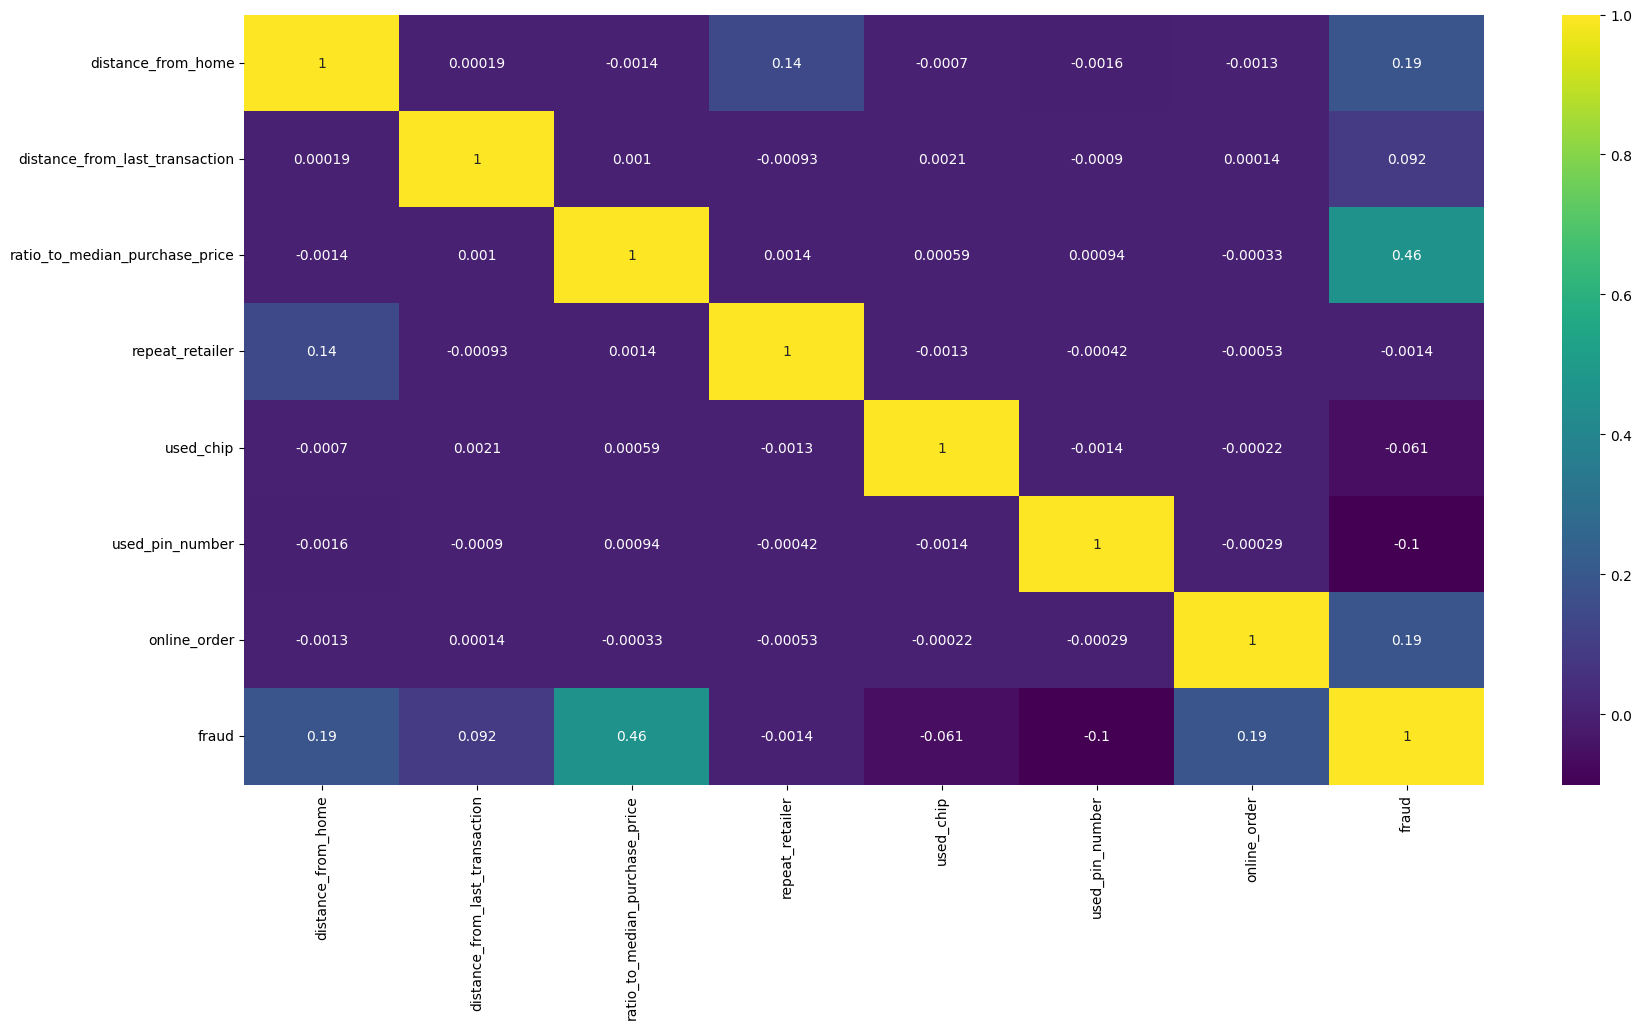

In [8]:
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr(), annot = True, cmap='viridis')
plt.show()

In [9]:
corr = data.corr()['fraud'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")

,fraud
fraud,1.000000
ratio_to_median_purchase_price,0.462305
online_order,0.191973
distance_from_home,0.187571
distance_from_last_transaction,0.091917
repeat_retailer,-0.001357
used_chip,-0.060975
used_pin_number,-0.100293


---

### Target Feature (Fraud)

In [10]:
data['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

### Categorical Features 

In [13]:
cat_features = ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']

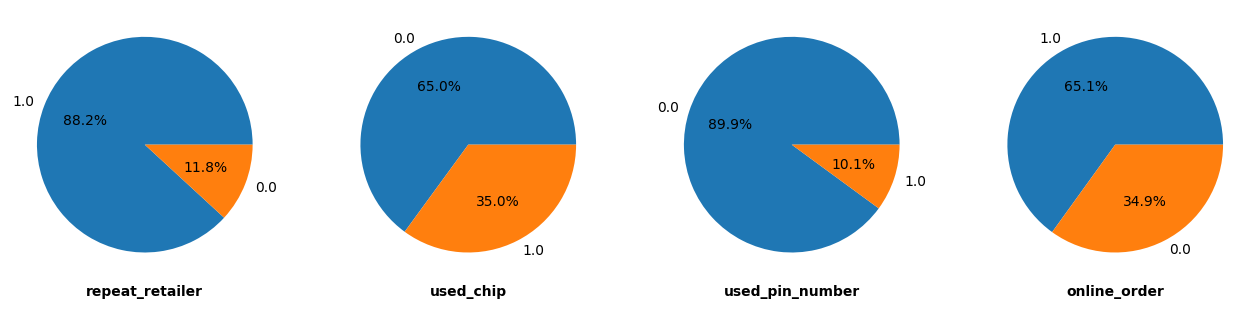

In [14]:
plt.figure(figsize = (16, 12))
for i, col in enumerate(cat_features):
    plt.subplot(1, 4, i+1)
    plt.pie(x = data[col].value_counts().values, 
            labels = data[col].value_counts().index, 
            autopct = '%1.1f%%')
    plt.xlabel(col, weight = 'bold')
plt.show()

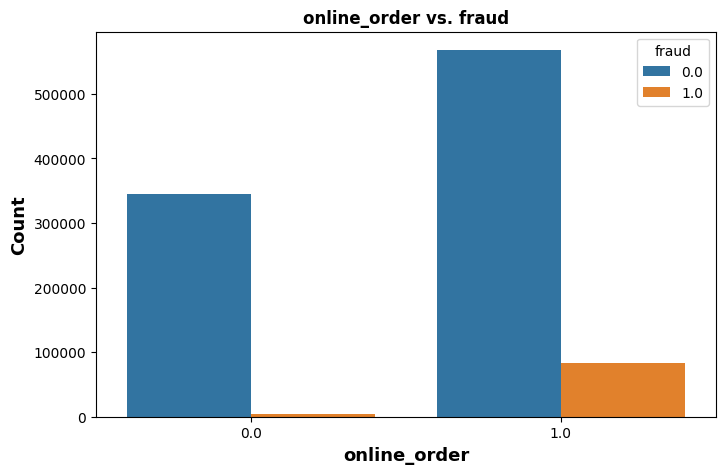

In [15]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'online_order',
              hue = 'fraud')


# Add labels and title
plt.title('online_order vs. fraud', weight = 'bold')
plt.xlabel('online_order', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

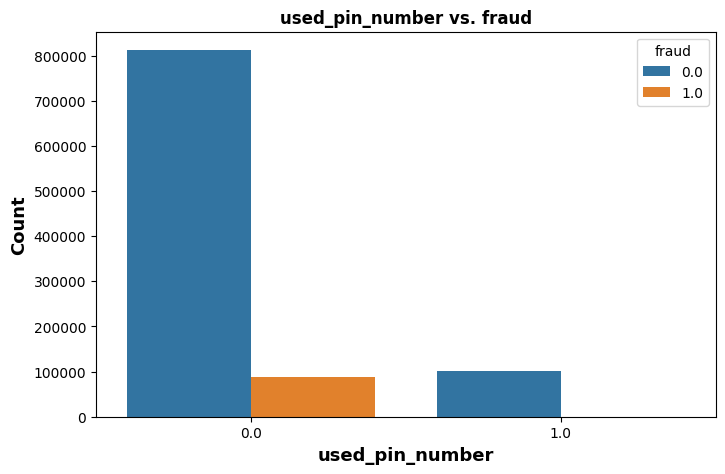

In [16]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'used_pin_number',
              hue = 'fraud')


# Add labels and title
plt.title('used_pin_number vs. fraud', weight = 'bold')
plt.xlabel('used_pin_number', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

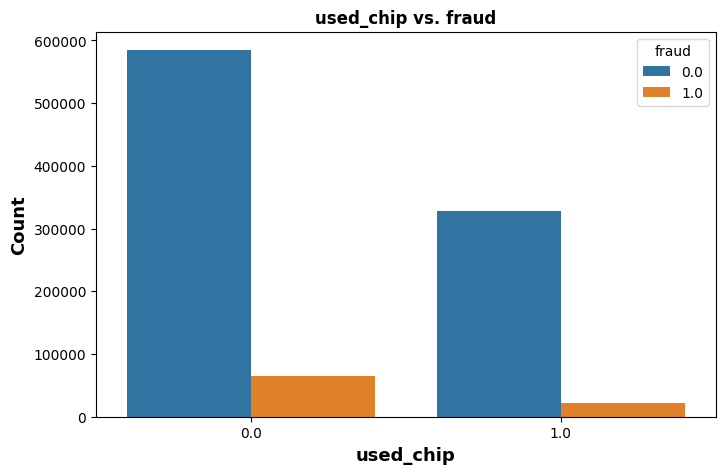

In [17]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'used_chip',
              hue = 'fraud')


# Add labels and title
plt.title('used_chip vs. fraud', weight = 'bold')
plt.xlabel('used_chip', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

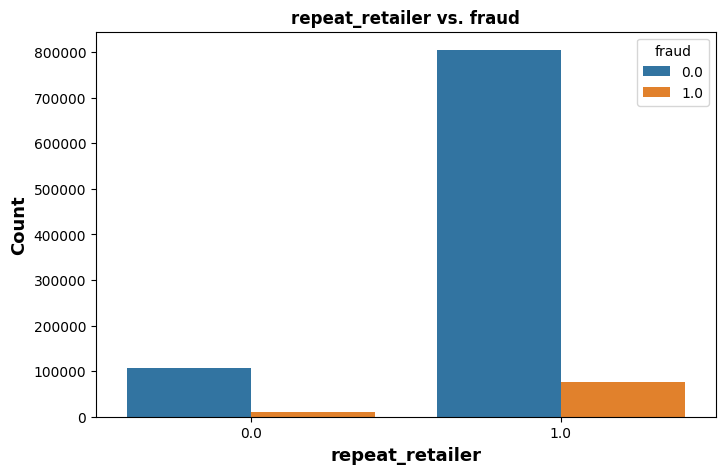

In [18]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'repeat_retailer',
              hue = 'fraud')


# Add labels and title
plt.title('repeat_retailer vs. fraud', weight = 'bold')
plt.xlabel('repeat_retailer', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

# Data Pre-processing

In [4]:
print(f' The number of samples before removing outliers: {data.shape[0]}')

 The number of samples before removing outliers: 1000000


In [5]:
num_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

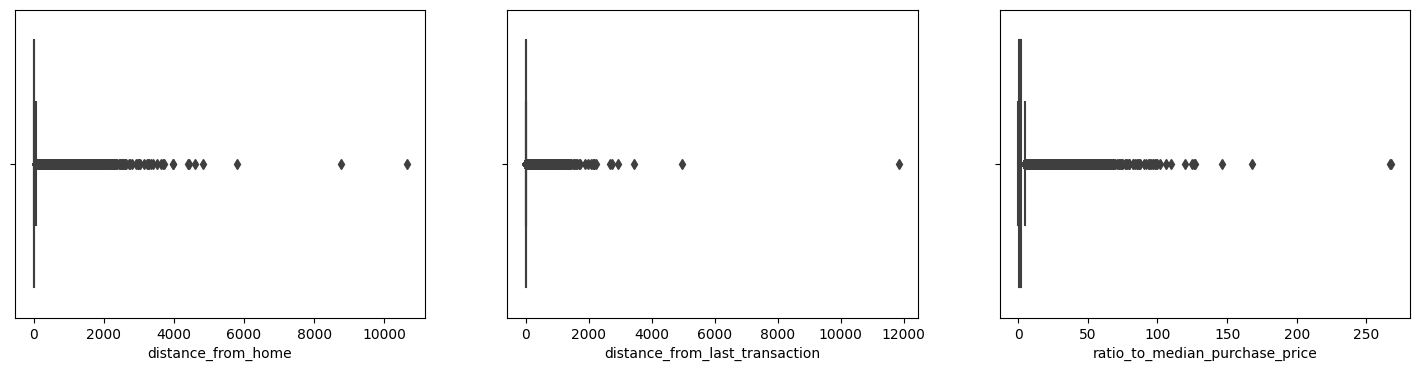

In [6]:
plt.figure(figsize = (18, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = data, x = col)
plt.show()

In [7]:
def remove_outliers(df, col):
    
    Q1 = df[col].quantile(0.25)

    Q3 = df[col].quantile(0.75)
    
    IQR = Q3 - Q1    
    
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

In [8]:
data_no_outliers = data.copy()
for col in num_features:
    data_no_outliers = remove_outliers(data_no_outliers, col)

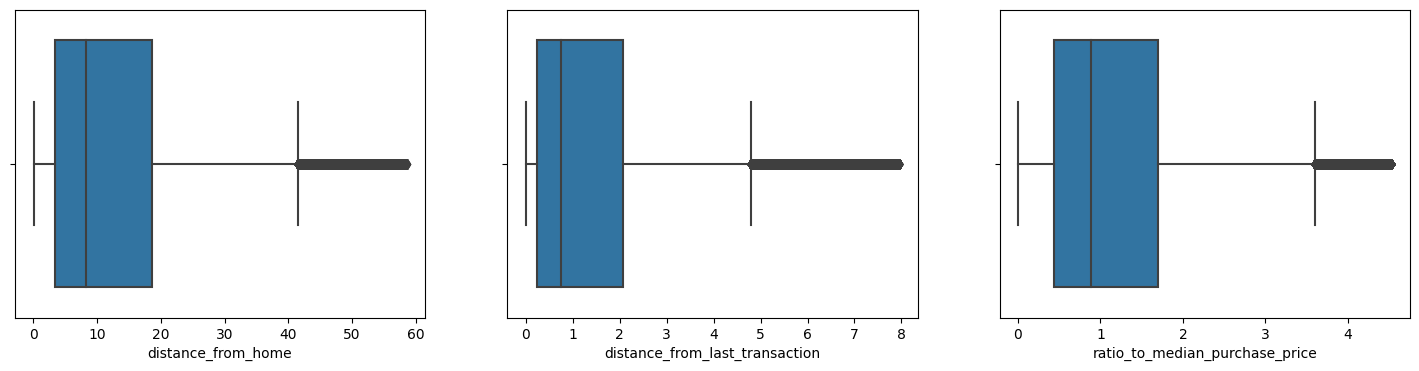

In [9]:
plt.figure(figsize = (18, 4))
for i, col in enumerate(num_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data = data_no_outliers, x = col)
plt.show()

In [10]:
print(f' The number of samples after removing outliers: {data_no_outliers.shape[0]}')

 The number of samples after removing outliers: 718686


## 2. Splitting Data

In [11]:
X = data_no_outliers.drop('fraud', axis = 1)
y = data_no_outliers['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 42)

In [12]:
print('X training shape = ', X_train.shape)
print('Y training shape = ', y_train.shape)
print('X test shape     = ', X_test.shape)
print('Y test shape     = ', y_test.shape)

X training shape =  (503080, 7)
Y training shape =  (503080,)
X test shape     =  (215606, 7)
Y test shape     =  (215606,)


## 3. Data Normalization (Scaling)

In [13]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [14]:
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## 4. Imbalanced Data 

SMOTE (Synthetic Minority Oversampling Technique) synthesizes elements for the minority class. SMOTE works by selecting examples that are close to the feature space, drawing a line between the examples in the feature space, and drawing a new sample at a point along that line.

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority', random_state = 42)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [16]:
y_train.value_counts()

fraud
0.0    496786
1.0      6294
Name: count, dtype: int64

In [17]:
y_train_os.value_counts()

fraud
0.0    496786
1.0    496786
Name: count, dtype: int64

---

---

# Modeling

In [33]:
def cross_validation_score(estimator_name, estimator, X_train, y_train, score = 'recall', n = 5):
    
    folds = StratifiedKFold(n_splits = n, shuffle = True, random_state = 42)
    
    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = folds)
    
    print(f'Cross Validation Scores of {estimator_name}: {validate} \n')
    print(f'Mean of Scores for {estimator_name}: {validate.mean()} \n')
    print(f'Standard Deviation of Scores for {estimator_name}: {validate.std()}')

In [55]:
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'recall', n = 5):
    
    random_cv = RandomizedSearchCV(estimator, param_grid, random_state=42,
                                  n_iter = 5, verbose = 2)
    
    # Fit the data
    random_cv.fit(X_train,y_train)
    
    best_params = random_cv.best_params_
    best_score = random_cv.best_score_
    
    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')
    
    # best estimator
    best_estimator = random_cv.best_estimator_
    
    return best_estimator

In [46]:
def model_evaluation(model, X_test, y_test, color = 'Reds'):
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0), '\n ')
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), cmap = color, annot = True, fmt = ".2f")
    plt.xlabel('Predicted', size = 12, weight = 'bold')
    plt.ylabel('Actual', size = 12, weight = 'bold')
    plt.title('Confusion Matrix', weight = 'bold')
    plt.show()

In [41]:
def roc_auc_curve_score(model, X_test, y_test):
        
    y_proba = model.predict_proba(X_test)
    
    score = roc_auc_score(y_test, y_proba[:, 1])
    
    fpr ,tpr ,thresholds = roc_curve(y_test, y_proba[:, 1])
    
    plt.figure(figsize = (8, 5))
    plt.plot(fpr, tpr, label = 'ROC_AUC Score (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc = "lower right")
    plt.show()

## 1. Logistic Regression

In [39]:
log_reg = LogisticRegression()

log_reg.fit(X_train_os, y_train_os)

LogisticRegression()

In [40]:
log_reg.score(X_train_os, y_train_os)

0.9968306272721051

### 1.2. Cross Validation

In [42]:
cross_validation_score('Logistic Regression', log_reg, X_train_os, y_train_os)

Cross Validation Scores of Logistic Regression: [0.99955715 0.99969806 0.99964773 0.99977858 0.99968799] 

Mean of Scores for Logistic Regression: 0.9996739038053452 

Standard Deviation of Scores for Logistic Regression: 7.218604264566155e-05


## Hyperparameter Tuning

In [57]:
param_grid = {
    'penalty': ['l1', 'l2'],               # Type of regularization
    'C': [0.1, 1, 10, 100],   # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],      # Optimization algorithm (depends on penalty)
    'max_iter': [100, 200, 300]            # Maximum number of iterations
}

hyperparameter_tunning(estimator = log_reg, X_train = X_train_os,y_train =  y_train_os, 
                      param_grid = param_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=  38.4s
[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=  37.8s
[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=  37.0s
[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=  37.0s
[CV] END ........C=10, max_iter=100, penalty=l2, solver=saga; total time=  35.2s
[CV] END ..C=100, max_iter=200, penalty=l1, solver=liblinear; total time= 2.1min
[CV] END ..C=100, max_iter=200, penalty=l1, solver=liblinear; total time= 2.2min
[CV] END ..C=100, max_iter=200, penalty=l1, solver=liblinear; total time= 2.7min
[CV] END ..C=100, max_iter=200, penalty=l1, solver=liblinear; total time= 1.8min
[CV] END ..C=100, max_iter=200, penalty=l1, solver=liblinear; total time= 1.8min
[CV] END ...C=10, max_iter=100, penalty=l2, solver=liblinear; total time=   2.8s
[CV] END ...C=10, max_iter=100, penalty=l2, solve

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time= 1.3min


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time= 1.2min


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time= 1.4min


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time= 1.4min


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, max_iter=100, penalty=l1, solver=liblinear; total time= 1.2min
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 200, 'C': 100} 

Best score: 0.9969061126197225


LogisticRegression(C=100, max_iter=200, solver='saga')

### 1.3. Model Evaluation

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    212908
         1.0       0.69      1.00      0.81      2698

    accuracy                           0.99    215606
   macro avg       0.84      1.00      0.91    215606
weighted avg       1.00      0.99      0.99    215606
 
 


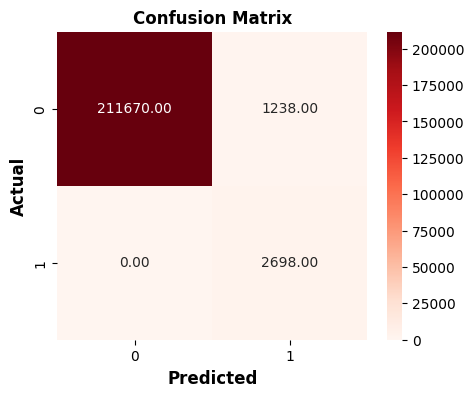

In [47]:
model_evaluation(log_reg, X_test, y_test)

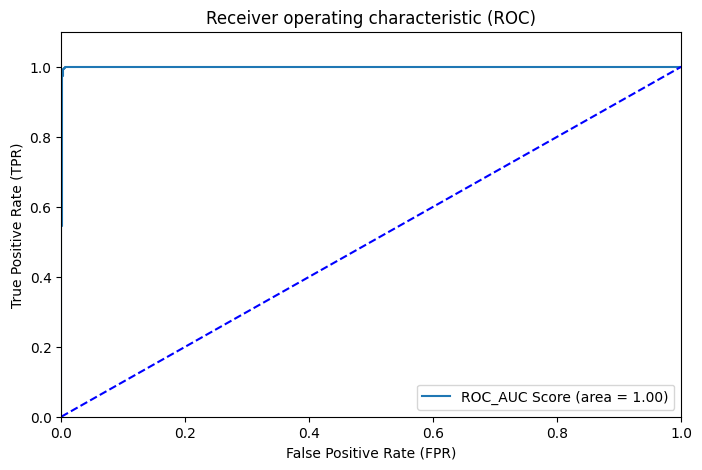

In [43]:
roc_auc_curve_score(log_reg, X_test, y_test)

---

## 2. Decision Tree

### 2.1. Creating The Model

In [19]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification problem
    eval_metric='logloss'          # Logarithmic loss for evaluation
)

In [20]:
xgb_classifier.fit(X_train_os, y_train_os)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [21]:
y_pred = xgb_classifier.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9999907238203019


In [26]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    212908
         1.0       1.00      1.00      1.00      2698

    accuracy                           1.00    215606
   macro avg       1.00      1.00      1.00    215606
weighted avg       1.00      1.00      1.00    215606



---

## 3. Random Forest

### 3.1 Creating The Model

In [48]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train_os, y_train_os)

RandomForestClassifier(n_estimators=200, random_state=42)

In [49]:
rf.score(X_train_os, y_train_os)

1.0

In [50]:
cross_validation_score('Random Forest', rf, X_train_os, y_train_os, n = 5)

Cross Validation Scores of Random Forest: [1. 1. 1. 1. 1.] 

Mean of Scores for Random Forest: 1.0 

Standard Deviation of Scores for Random Forest: 0.0


### 3.3. Model Evaluation

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    212908
         1.0       1.00      1.00      1.00      2698

    accuracy                           1.00    215606
   macro avg       1.00      1.00      1.00    215606
weighted avg       1.00      1.00      1.00    215606
 
 


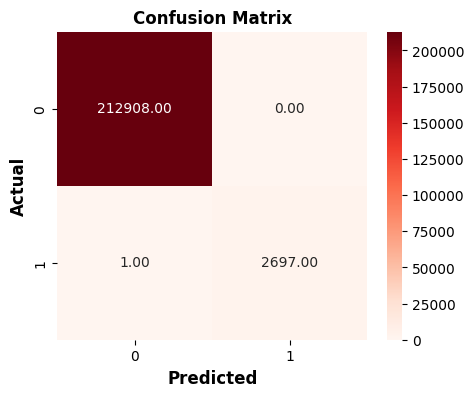

In [51]:
model_evaluation(rf, X_test, y_test)

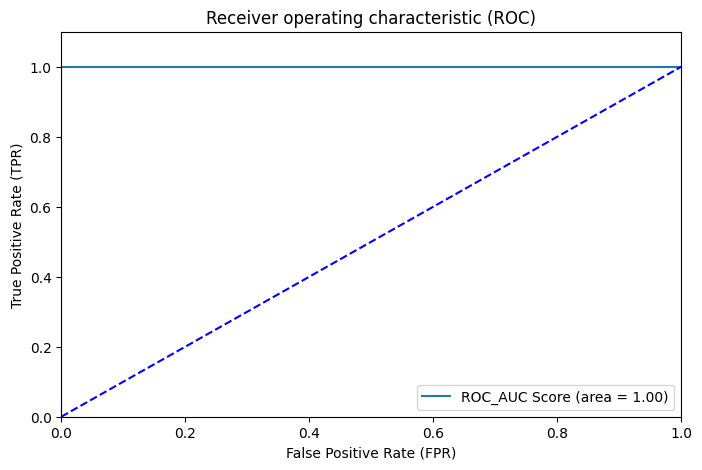

In [52]:
roc_auc_curve_score(rf, X_test, y_test)

## Conclusion

<p>Comparing these three models, we conclude that <b>the Random Forest Classifier model is the best model</b> to be able to detect credit card fraud from our dataset.

# Done!